In [24]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [25]:
train_df = pd.read_csv('train.csv')
train_target = train_df.pop('IN_TREINEIRO')
test_df = pd.read_csv('test.csv')
test_columns = test_df.columns.values
train_df = train_df[test_columns]
train_df.drop('NU_INSCRICAO', axis=1, inplace=True)
test_inscricao = test_df.pop('NU_INSCRICAO')

In [26]:
train_df.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,24,M,1,1,1,4,1,NaN,...,80.0,520.0,D,D,C,A,A,C,H,A
1,23,CE,17,F,3,1,2,0,2,1.0,...,80.0,580.0,A,A,B,A,A,A,NaN,A
2,23,CE,21,F,3,1,3,0,1,NaN,...,NaN,NaN,D,D,C,A,A,A,NaN,A
3,33,RJ,25,F,0,1,1,9,1,NaN,...,NaN,NaN,H,E,E,C,B,C,F,D
4,13,AM,28,M,2,1,1,4,1,NaN,...,NaN,NaN,E,D,C,A,A,B,F,A


In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 42 columns):
CO_UF_RESIDENCIA          13730 non-null int64
SG_UF_RESIDENCIA          13730 non-null object
NU_IDADE                  13730 non-null int64
TP_SEXO                   13730 non-null object
TP_COR_RACA               13730 non-null int64
TP_NACIONALIDADE          13730 non-null int64
TP_ST_CONCLUSAO           13730 non-null int64
TP_ANO_CONCLUIU           13730 non-null int64
TP_ESCOLA                 13730 non-null int64
TP_ENSINO                 4282 non-null float64
TP_DEPENDENCIA_ADM_ESC    4282 non-null float64
IN_BAIXA_VISAO            13730 non-null int64
IN_CEGUEIRA               13730 non-null int64
IN_SURDEZ                 13730 non-null int64
IN_DISLEXIA               13730 non-null int64
IN_DISCALCULIA            13730 non-null int64
IN_SABATISTA              13730 non-null int64
IN_GESTANTE               13730 non-null int64
IN_IDOSO                  13730 non-null 

In [28]:
train_target.describe()

count    13730.000000
mean         0.129862
std          0.336163
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: IN_TREINEIRO, dtype: float64

In [29]:
test_df.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,19,F,1,1,1,3,1,NaN,...,NaN,NaN,E,E,H,B,B,C,D,A
1,15,PA,24,M,3,2,1,4,1,NaN,...,NaN,NaN,B,C,B,A,A,C,D,A
2,29,BA,16,F,2,1,3,0,1,NaN,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,41,PR,17,F,1,1,2,0,2,1.0,...,40.0,480.0,E,E,E,C,B,B,C,A
4,53,DF,19,F,1,1,1,1,1,NaN,...,80.0,720.0,E,E,E,B,B,B,D,A


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4570 entries, 0 to 4569
Data columns (total 42 columns):
CO_UF_RESIDENCIA          4570 non-null int64
SG_UF_RESIDENCIA          4570 non-null object
NU_IDADE                  4570 non-null int64
TP_SEXO                   4570 non-null object
TP_COR_RACA               4570 non-null int64
TP_NACIONALIDADE          4570 non-null int64
TP_ST_CONCLUSAO           4570 non-null int64
TP_ANO_CONCLUIU           4570 non-null int64
TP_ESCOLA                 4570 non-null int64
TP_ENSINO                 1426 non-null float64
TP_DEPENDENCIA_ADM_ESC    1426 non-null float64
IN_BAIXA_VISAO            4570 non-null int64
IN_CEGUEIRA               4570 non-null int64
IN_SURDEZ                 4570 non-null int64
IN_DISLEXIA               4570 non-null int64
IN_DISCALCULIA            4570 non-null int64
IN_SABATISTA              4570 non-null int64
IN_GESTANTE               4570 non-null int64
IN_IDOSO                  4570 non-null int64
TP_PRESENCA_C

In [31]:
numeric_features = train_df.select_dtypes(include='number').columns.values
cat_features = train_df.select_dtypes(exclude='number').columns.values
processors = {'num_imputer': SimpleImputer(strategy='median'),
              'scaler': StandardScaler(),
              'cat_imputer': SimpleImputer(strategy='constant', fill_value='NA')}
def preprocess_fit(df, processors):
    num_df = df[numeric_features]
    cat_df = df[cat_features]
    num_processed = processors['num_imputer'].fit_transform(num_df)
    #num_processed = processors['scaler'].fit_transform(num_processed)
    num_df = pd.DataFrame(num_processed, columns=num_df.columns)
    cat_processed = processors['cat_imputer'].fit_transform(cat_df)
    cat_df = pd.DataFrame(cat_processed, columns=cat_df.columns)
    return pd.concat((num_df, cat_df), axis=1)
    
train_df = preprocess_fit(train_df, processors)

In [32]:
train_df.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,...,SG_UF_RESIDENCIA,TP_SEXO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43.0,24.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,0.0,...,RS,M,D,D,C,A,A,C,H,A
1,23.0,17.0,3.0,1.0,2.0,0.0,2.0,1.0,2.0,0.0,...,CE,F,A,A,B,A,A,A,NA,A
2,23.0,21.0,3.0,1.0,3.0,0.0,1.0,1.0,2.0,0.0,...,CE,F,D,D,C,A,A,A,NA,A
3,33.0,25.0,0.0,1.0,1.0,9.0,1.0,1.0,2.0,0.0,...,RJ,F,H,E,E,C,B,C,F,D
4,13.0,28.0,2.0,1.0,1.0,4.0,1.0,1.0,2.0,0.0,...,AM,M,E,D,C,A,A,B,F,A


In [33]:
def preprocess_transform(df, processors):
    num_df = df[numeric_features]
    cat_df = df[cat_features]
    num_processed = processors['num_imputer'].transform(num_df)
    #num_processed = processors['scaler'].transform(num_processed)
    num_df = pd.DataFrame(num_processed, columns=num_df.columns)
    cat_processed = processors['cat_imputer'].transform(cat_df)
    cat_df = pd.DataFrame(cat_processed, columns=cat_df.columns)
    return pd.concat((num_df, cat_df), axis=1)
    
test_df = preprocess_transform(test_df, processors)


In [34]:
test_df.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,...,SG_UF_RESIDENCIA,TP_SEXO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43.0,19.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,0.0,...,RS,F,E,E,H,B,B,C,D,A
1,15.0,24.0,3.0,2.0,1.0,4.0,1.0,1.0,2.0,0.0,...,PA,M,B,C,B,A,A,C,D,A
2,29.0,16.0,2.0,1.0,3.0,0.0,1.0,1.0,2.0,0.0,...,BA,F,E,F,G,B,B,A,NA,D
3,41.0,17.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,0.0,...,PR,F,E,E,E,C,B,B,C,A
4,53.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,...,DF,F,E,E,E,B,B,B,D,A


In [35]:
cat = CatBoostClassifier(cat_features=cat_features)

In [36]:
cat.fit(train_df, train_target)

Learning rate set to 0.03153
0:	learn: 0.5873118	total: 31.7ms	remaining: 31.6s
1:	learn: 0.4965702	total: 61.3ms	remaining: 30.6s
2:	learn: 0.4237562	total: 90.7ms	remaining: 30.2s
3:	learn: 0.3592273	total: 109ms	remaining: 27.2s
4:	learn: 0.3054241	total: 136ms	remaining: 27s
5:	learn: 0.2604828	total: 156ms	remaining: 25.8s
6:	learn: 0.2229919	total: 183ms	remaining: 25.9s
7:	learn: 0.1857374	total: 210ms	remaining: 26s
8:	learn: 0.1564399	total: 238ms	remaining: 26.2s
9:	learn: 0.1338687	total: 265ms	remaining: 26.2s
10:	learn: 0.1141476	total: 289ms	remaining: 25.9s
11:	learn: 0.0979413	total: 314ms	remaining: 25.9s
12:	learn: 0.0848893	total: 340ms	remaining: 25.8s
13:	learn: 0.0737815	total: 369ms	remaining: 26s
14:	learn: 0.0643629	total: 396ms	remaining: 26s
15:	learn: 0.0565457	total: 423ms	remaining: 26s
16:	learn: 0.0502358	total: 446ms	remaining: 25.8s
17:	learn: 0.0447174	total: 474ms	remaining: 25.8s
18:	learn: 0.0398219	total: 504ms	remaining: 26s
19:	learn: 0.0361858	

162:	learn: 0.0077221	total: 4s	remaining: 20.5s
163:	learn: 0.0077118	total: 4.02s	remaining: 20.5s
164:	learn: 0.0076915	total: 4.05s	remaining: 20.5s
165:	learn: 0.0076857	total: 4.07s	remaining: 20.4s
166:	learn: 0.0076215	total: 4.09s	remaining: 20.4s
167:	learn: 0.0076157	total: 4.12s	remaining: 20.4s
168:	learn: 0.0076084	total: 4.14s	remaining: 20.4s
169:	learn: 0.0076016	total: 4.16s	remaining: 20.3s
170:	learn: 0.0075748	total: 4.19s	remaining: 20.3s
171:	learn: 0.0075692	total: 4.22s	remaining: 20.3s
172:	learn: 0.0075361	total: 4.26s	remaining: 20.3s
173:	learn: 0.0075050	total: 4.29s	remaining: 20.4s
174:	learn: 0.0075033	total: 4.32s	remaining: 20.3s
175:	learn: 0.0074988	total: 4.34s	remaining: 20.3s
176:	learn: 0.0074977	total: 4.36s	remaining: 20.3s
177:	learn: 0.0074810	total: 4.39s	remaining: 20.3s
178:	learn: 0.0074720	total: 4.42s	remaining: 20.3s
179:	learn: 0.0074657	total: 4.45s	remaining: 20.3s
180:	learn: 0.0074639	total: 4.48s	remaining: 20.3s
181:	learn: 0.0

321:	learn: 0.0061320	total: 8.34s	remaining: 17.6s
322:	learn: 0.0061297	total: 8.36s	remaining: 17.5s
323:	learn: 0.0061085	total: 8.38s	remaining: 17.5s
324:	learn: 0.0061058	total: 8.4s	remaining: 17.4s
325:	learn: 0.0061035	total: 8.43s	remaining: 17.4s
326:	learn: 0.0061026	total: 8.44s	remaining: 17.4s
327:	learn: 0.0060608	total: 8.48s	remaining: 17.4s
328:	learn: 0.0060516	total: 8.51s	remaining: 17.4s
329:	learn: 0.0060319	total: 8.54s	remaining: 17.3s
330:	learn: 0.0060231	total: 8.57s	remaining: 17.3s
331:	learn: 0.0060220	total: 8.58s	remaining: 17.3s
332:	learn: 0.0059944	total: 8.61s	remaining: 17.2s
333:	learn: 0.0059763	total: 8.64s	remaining: 17.2s
334:	learn: 0.0059675	total: 8.66s	remaining: 17.2s
335:	learn: 0.0059663	total: 8.69s	remaining: 17.2s
336:	learn: 0.0059663	total: 8.7s	remaining: 17.1s
337:	learn: 0.0059530	total: 8.74s	remaining: 17.1s
338:	learn: 0.0059530	total: 8.75s	remaining: 17.1s
339:	learn: 0.0059449	total: 8.78s	remaining: 17s
340:	learn: 0.00

486:	learn: 0.0048816	total: 13s	remaining: 13.7s
487:	learn: 0.0048719	total: 13s	remaining: 13.7s
488:	learn: 0.0048673	total: 13.1s	remaining: 13.6s
489:	learn: 0.0048648	total: 13.1s	remaining: 13.6s
490:	learn: 0.0048646	total: 13.1s	remaining: 13.6s
491:	learn: 0.0048646	total: 13.1s	remaining: 13.6s
492:	learn: 0.0048635	total: 13.2s	remaining: 13.5s
493:	learn: 0.0048597	total: 13.2s	remaining: 13.5s
494:	learn: 0.0048493	total: 13.2s	remaining: 13.5s
495:	learn: 0.0048343	total: 13.3s	remaining: 13.5s
496:	learn: 0.0048295	total: 13.3s	remaining: 13.5s
497:	learn: 0.0048237	total: 13.3s	remaining: 13.4s
498:	learn: 0.0048127	total: 13.4s	remaining: 13.4s
499:	learn: 0.0048044	total: 13.4s	remaining: 13.4s
500:	learn: 0.0047940	total: 13.4s	remaining: 13.4s
501:	learn: 0.0047915	total: 13.5s	remaining: 13.4s
502:	learn: 0.0047866	total: 13.5s	remaining: 13.4s
503:	learn: 0.0047862	total: 13.5s	remaining: 13.3s
504:	learn: 0.0047859	total: 13.6s	remaining: 13.3s
505:	learn: 0.00

645:	learn: 0.0040491	total: 18.1s	remaining: 9.92s
646:	learn: 0.0040375	total: 18.1s	remaining: 9.9s
647:	learn: 0.0040290	total: 18.2s	remaining: 9.88s
648:	learn: 0.0040234	total: 18.2s	remaining: 9.85s
649:	learn: 0.0040178	total: 18.2s	remaining: 9.82s
650:	learn: 0.0040125	total: 18.3s	remaining: 9.8s
651:	learn: 0.0040125	total: 18.3s	remaining: 9.77s
652:	learn: 0.0040083	total: 18.3s	remaining: 9.74s
653:	learn: 0.0040075	total: 18.4s	remaining: 9.72s
654:	learn: 0.0040047	total: 18.4s	remaining: 9.69s
655:	learn: 0.0040009	total: 18.4s	remaining: 9.66s
656:	learn: 0.0039988	total: 18.5s	remaining: 9.63s
657:	learn: 0.0039988	total: 18.5s	remaining: 9.61s
658:	learn: 0.0039984	total: 18.5s	remaining: 9.58s
659:	learn: 0.0039905	total: 18.6s	remaining: 9.56s
660:	learn: 0.0039904	total: 18.6s	remaining: 9.53s
661:	learn: 0.0039823	total: 18.6s	remaining: 9.51s
662:	learn: 0.0039716	total: 18.7s	remaining: 9.48s
663:	learn: 0.0039706	total: 18.7s	remaining: 9.46s
664:	learn: 0.

809:	learn: 0.0034162	total: 23.5s	remaining: 5.51s
810:	learn: 0.0034126	total: 23.5s	remaining: 5.48s
811:	learn: 0.0034126	total: 23.6s	remaining: 5.45s
812:	learn: 0.0034126	total: 23.6s	remaining: 5.42s
813:	learn: 0.0034082	total: 23.6s	remaining: 5.4s
814:	learn: 0.0034028	total: 23.7s	remaining: 5.37s
815:	learn: 0.0034010	total: 23.7s	remaining: 5.34s
816:	learn: 0.0033982	total: 23.7s	remaining: 5.31s
817:	learn: 0.0033957	total: 23.8s	remaining: 5.28s
818:	learn: 0.0033957	total: 23.8s	remaining: 5.25s
819:	learn: 0.0033957	total: 23.8s	remaining: 5.23s
820:	learn: 0.0033957	total: 23.8s	remaining: 5.2s
821:	learn: 0.0033952	total: 23.9s	remaining: 5.17s
822:	learn: 0.0033918	total: 23.9s	remaining: 5.14s
823:	learn: 0.0033903	total: 23.9s	remaining: 5.11s
824:	learn: 0.0033902	total: 23.9s	remaining: 5.08s
825:	learn: 0.0033844	total: 24s	remaining: 5.05s
826:	learn: 0.0033784	total: 24s	remaining: 5.03s
827:	learn: 0.0033767	total: 24.1s	remaining: 5s
828:	learn: 0.0033742

969:	learn: 0.0030498	total: 28.3s	remaining: 876ms
970:	learn: 0.0030488	total: 28.3s	remaining: 847ms
971:	learn: 0.0030488	total: 28.4s	remaining: 817ms
972:	learn: 0.0030440	total: 28.4s	remaining: 788ms
973:	learn: 0.0030440	total: 28.4s	remaining: 759ms
974:	learn: 0.0030419	total: 28.5s	remaining: 730ms
975:	learn: 0.0030417	total: 28.5s	remaining: 701ms
976:	learn: 0.0030415	total: 28.5s	remaining: 672ms
977:	learn: 0.0030404	total: 28.5s	remaining: 642ms
978:	learn: 0.0030404	total: 28.6s	remaining: 613ms
979:	learn: 0.0030402	total: 28.6s	remaining: 584ms
980:	learn: 0.0030402	total: 28.6s	remaining: 555ms
981:	learn: 0.0030400	total: 28.7s	remaining: 525ms
982:	learn: 0.0030400	total: 28.7s	remaining: 496ms
983:	learn: 0.0030380	total: 28.7s	remaining: 467ms
984:	learn: 0.0030353	total: 28.7s	remaining: 438ms
985:	learn: 0.0030351	total: 28.8s	remaining: 408ms
986:	learn: 0.0030351	total: 28.8s	remaining: 379ms
987:	learn: 0.0030327	total: 28.8s	remaining: 350ms
988:	learn: 

In [37]:
answers = cat.predict(test_df)
answers = pd.Series(answers, name='IN_TREINEIRO')

In [38]:
result_df = pd.concat((test_inscricao, answers), axis=1)
result_df.set_index('NU_INSCRICAO', inplace=True)

In [39]:
result_df.head()

,IN_TREINEIRO
NU_INSCRICAO,
ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
177f281c68fa032aedbd842a745da68490926cd2,0
6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
5c356d810fa57671402502cd0933e5601a2ebf1e,0
df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0


In [40]:
result_df.to_csv('answer.csv')

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

In [42]:
eli5.explain_weights(cat)

Weight,Feature
0.4910,TP_ST_CONCLUSAO
0.1625,NU_IDADE
0.1220,TP_ESCOLA
0.0218,Q001
0.0198,CO_UF_RESIDENCIA
0.0159,SG_UF_RESIDENCIA
0.0159,NU_NOTA_CN
0.0138,NU_NOTA_CH
0.0133,TP_ANO_CONCLUIU
0.0132,Q002


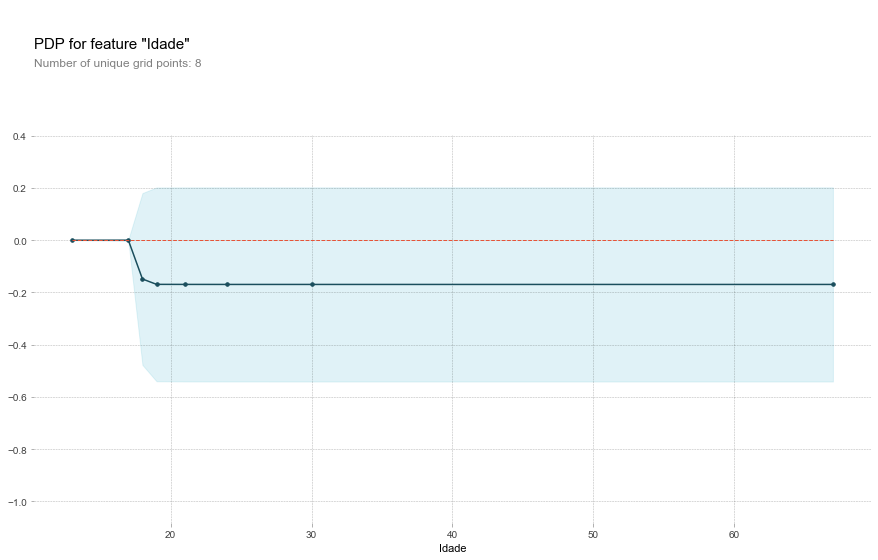

In [43]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

pdp_conclusao = pdp.pdp_isolate(model=cat, 
                                dataset=train_df, 
                                model_features=train_df.columns, 
                                feature='NU_IDADE')

# plot it
pdp.pdp_plot(pdp_conclusao, 'Idade')
plt.show()

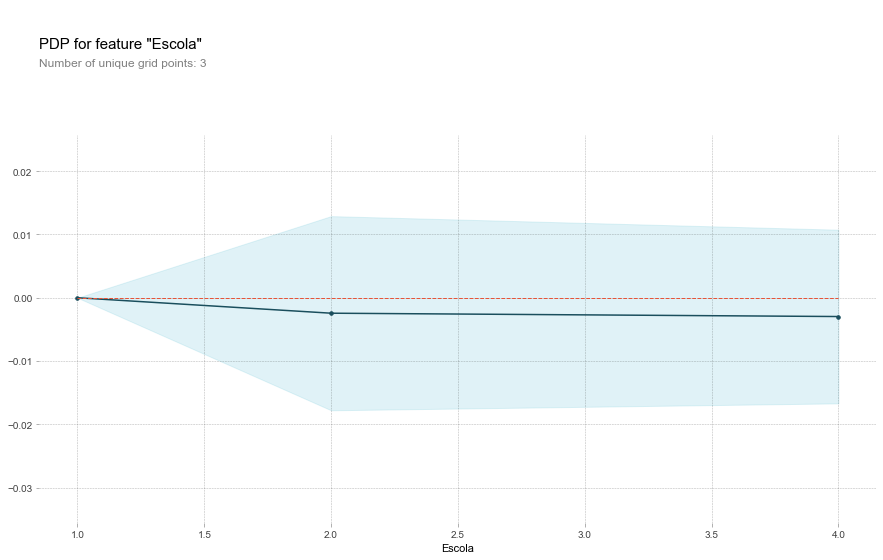

In [44]:
pdp_conclusao = pdp.pdp_isolate(model=cat, 
                                dataset=train_df, 
                                model_features=train_df.columns, 
                                feature='TP_ESCOLA')

# plot it
pdp.pdp_plot(pdp_conclusao, 'Escola')
plt.show()

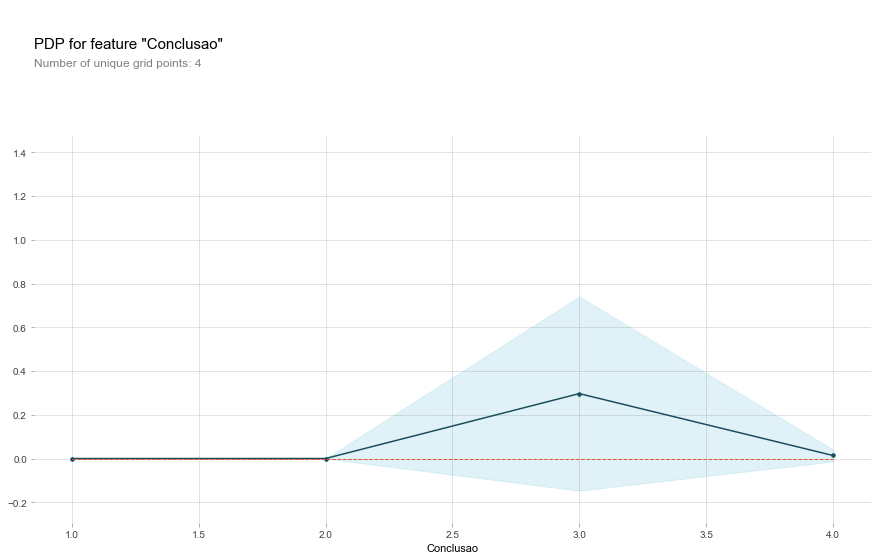

In [45]:
pdp_conclusao = pdp.pdp_isolate(model=cat, 
                                dataset=train_df, 
                                model_features=train_df.columns, 
                                feature='TP_ST_CONCLUSAO')

# plot it
pdp.pdp_plot(pdp_conclusao, 'Conclusao')
plt.show()